# TensorFlow

**[MDR-01]** 必要なモジュールをインポートします。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

/Users/yohei/.pyenv/versions/anaconda3-5.0.0/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**[MDR-02]** MNISTのデータセットを用意します。

In [2]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


**[MDR-03]** フィルターに対応する Variable を用意して、入力データにフィルターとプーリング層を適用する計算式を定義します。

学習済みモデルを読み込んで実験する場合，モデルの定義(変数(Variable)名)は同じにしないといけない．  
全く同じ計算式を立てる必要がある．

In [3]:
num_filters = 16

x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1])  # NWHC

#FH FW C FN  [filter_height, filter_width, in_channels, out_channels]
W_conv = tf.Variable(tf.truncated_normal([5,5,1,num_filters], stddev=0.1), name='W_conv')

h_conv = tf.nn.conv2d(x_image, W_conv,
                      strides=[1,1,1,1], padding='SAME')
h_pool =tf.nn.max_pool(h_conv, ksize=[1,2,2,1],
                       strides=[1,2,2,1], padding='SAME')

**[MDR-04]** プーリング層からの出力を全結合層を経由してソフトマックス関数に入力する計算式を定義します。

In [4]:
h_pool_flat = tf.reshape(h_pool, [-1, 14*14*num_filters])  # 全結合層につなぐためflatにする

num_units1 = 14*14*num_filters
num_units2 = 1024

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]), name='w2')
b2 = tf.Variable(tf.zeros([num_units2]), name='b2')
hidden2 = tf.nn.relu(tf.matmul(h_pool_flat, w2) + b2)

w0 = tf.Variable(tf.zeros([num_units2, 10]), name='w0')
b0 = tf.Variable(tf.zeros([10]), name='b0')
p = tf.nn.softmax(tf.matmul(hidden2, w0) + b0)

**[MDR-05]** 誤差関数 loss、トレーニングアルゴリズム train_step、正解率 accuracy を定義します。

In [5]:
t = tf.placeholder(tf.float32, [None, 10])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer(0.0005).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

**[MDR-06]** セッションを用意して Variable を初期化した後、最適化処理を実施済みのセッションを復元します。

In [6]:
sess = tf.Session()
#sess.run(tf.global_variables_initializer())  #学習済みモデルを扱う場合，変数の初期化は不要
saver = tf.train.Saver()  # モデル読み込み用
saver.restore(sess, 'tensorflow_session/mdc_session-4000')

INFO:tensorflow:Restoring parameters from tensorflow_session/mdc_session-4000


**[MDR-07]** 畳込みフィルターの値と、最初の9個分の画像データに対して、畳み込みフィルターとプーリング層を適用した結果を取得します。

In [7]:
filter_vals, conv_vals, pool_vals = sess.run(
    [W_conv, h_conv, h_pool], feed_dict={x:mnist.test.images[:9]})

In [8]:
filter_vals.shape, conv_vals.shape, pool_vals.shape

((5, 5, 1, 16), (9, 28, 28, 16), (9, 14, 14, 16))

**[MDR-08]** 畳込みフィルターを適用した結果を画像として表示します。

畳込みフィルターを適用した後は、ピクセル値が負の値をとることもあるため、背景（ピクセル値 0）の部分が白にならない点に注意してください。

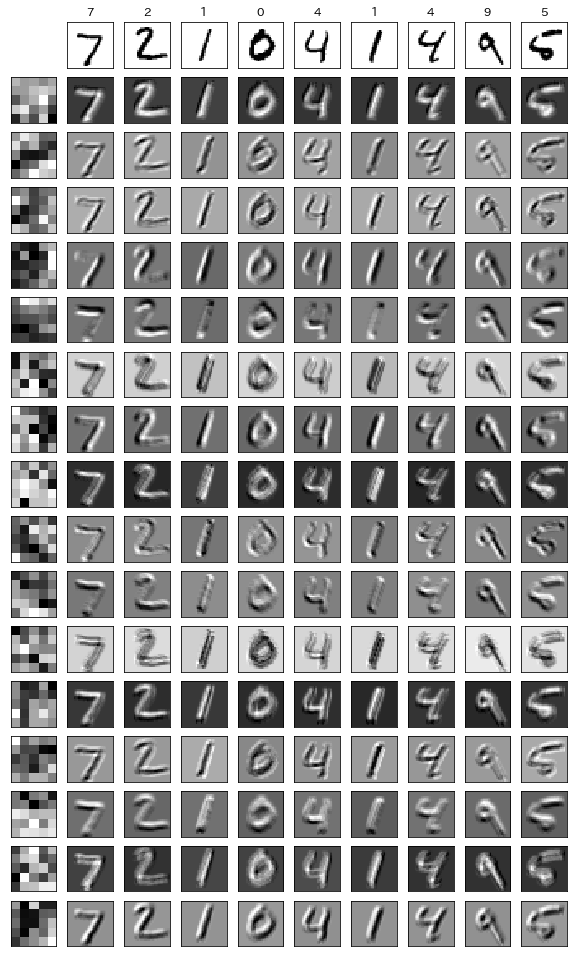

In [9]:
fig = plt.figure(figsize=(10,num_filters+1))

# フィルターを表示
for i in range(num_filters):
    subplot = fig.add_subplot(num_filters+1, 10, 10*(i+1)+1)  # https://openbook4.me/sections/1696
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

# 元の画像とそれにフィルターをかけた値を表示
for i in range(9):
    # 元の画像データを表示
    subplot = fig.add_subplot(num_filters+1, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(mnist.test.labels[i]))
    subplot.imshow(mnist.test.images[i].reshape((28,28)),
                   vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')

    # 畳こみ後の画像を表示
    for f in range(num_filters):
        subplot = fig.add_subplot(num_filters+1, 10, 10*(f+1)+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(conv_vals[i,:,:,f],  # conv_vals[i,:,:,f] : i番目のデータのf番目フィルターによる畳み込み後の画像
                       cmap=plt.cm.gray_r, interpolation='nearest')

**[MDR-09]** 同じく、畳込みフィルターとプーリング層を適用した結果を画像として表示します。

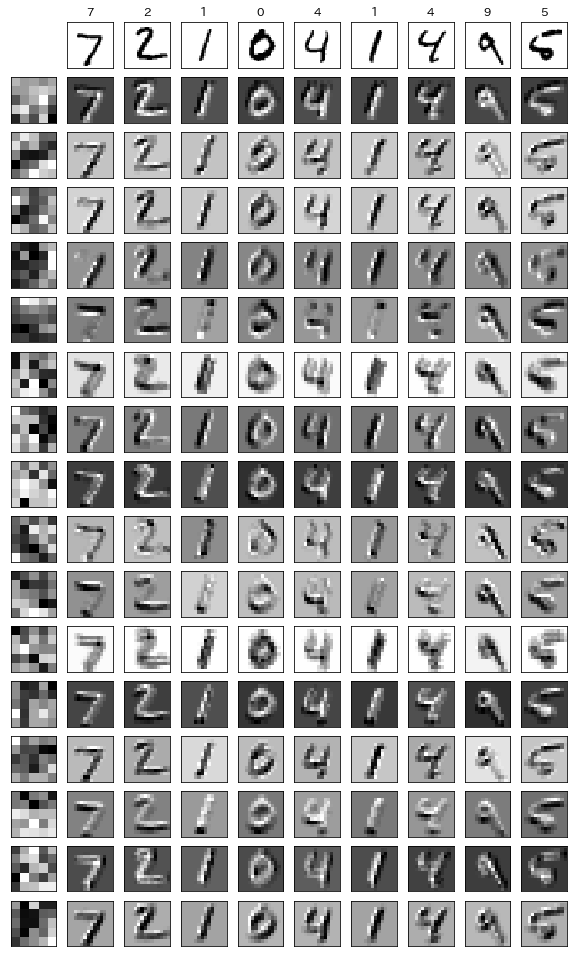

In [10]:
fig = plt.figure(figsize=(10,num_filters+1))

for i in range(num_filters):
    subplot = fig.add_subplot(num_filters+1, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

for i in range(9):
    subplot = fig.add_subplot(num_filters+1, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(mnist.test.labels[i]))
    subplot.imshow(mnist.test.images[i].reshape((28,28)),
                   vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')

    for f in range(num_filters):
        subplot = fig.add_subplot(num_filters+1, 10, 10*(f+1)+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(pool_vals[i,:,:,f],
                       cmap=plt.cm.gray_r, interpolation='nearest') 

**[MDR-10]** 正しく分類できなかったいくつかのデータについて、それぞれの文字である確率を確認します。

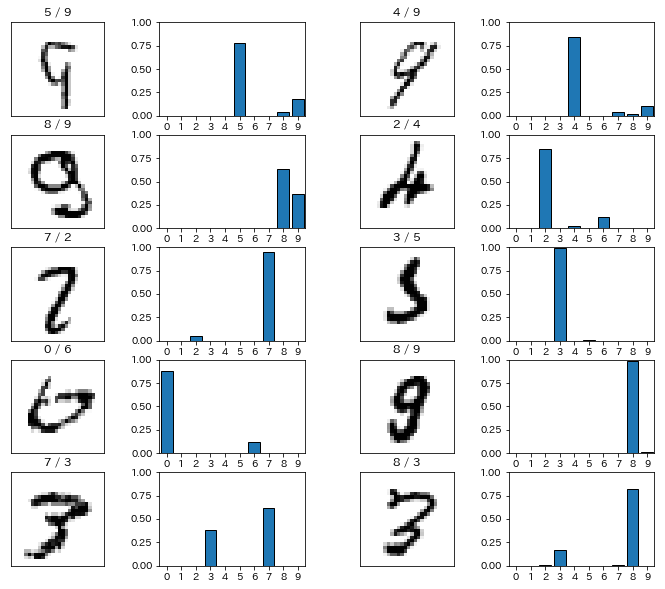

In [11]:
fig = plt.figure(figsize=(12,10))
c=0
for (image, label) in zip(mnist.test.images, 
                          mnist.test.labels):
    p_val = sess.run(p, feed_dict={x:[image]})
    pred = p_val[0]  # p_val shape = (1, 10)
    prediction, actual = np.argmax(pred), np.argmax(label)
    if prediction == actual:
        continue  # 予想と結果が合っていれば continue
    subplot = fig.add_subplot(5,4,c*2+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d / %d' % (prediction, actual))
    subplot.imshow(image.reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation="nearest")
    subplot = fig.add_subplot(5,4,c*2+2)
    subplot.set_xticks(range(10))
    subplot.set_xlim(-0.5,9.5)
    subplot.set_ylim(0,1)
    subplot.bar(range(10), pred, align='center')
    c += 1
    if c == 10:  # 10枚描画できたら終了
        break

In [16]:
p_val[0].shape

(10,)

# Keras

In [3]:
from keras.models import load_model

Using TensorFlow backend.


In [5]:
# モデルのリストア
model = load_model('keras_session/model_06_vloss0.047.hdf5')

Kerasの場合，TensorFlowのように変数名の設定を合わせる必要がない  
Kerasではモデルをそのまま保存・読み込みを行うため

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution (Conv2D)         (None, 28, 28, 16)        400       
_________________________________________________________________
pool (MaxPooling2D)          (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
fully-connected (Dense)      (None, 1024)              3212288   
_________________________________________________________________
softmax (Dense)              (None, 10)                10250     
Total params: 3,222,938
Trainable params: 3,222,938
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.models import Model

In [13]:
# 中間層の出力を得るためには新たなModel を作成

# まずはinputのTensorを取得
input_layer = model.get_layer('convolution').input
# input_layer = model.input でも同じ?

In [14]:
# outputのTensorを取得
conv, pool, output = model.get_layer('convolution').output, model.get_layer('pool').output, model.output

In [15]:
# 1入力で途中の結果を得るモデルを作成
intermediate_layer_model = Model(inputs=input_layer,
                                                            output=[conv, pool, output])

/Users/yohei/.pyenv/versions/anaconda3-5.0.0/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("co...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
# データを用意
x_test, t_test = mnist.test.images,mnist.test.labels
x_test = x_test.reshape(-1,28, 28, 1)
x_test.shape, t_test.shape

((10000, 28, 28, 1), (10000, 10))

In [31]:
# 畳み込み後の結果を取得
conv_vals, pool_vals, _ = intermediate_layer_model.predict(x_test[:9], batch_size=x_test[:9].shape[0], verbose=1)

9/9 [==============================] - 0s 1ms/step


In [32]:
# 畳み込みカーネルを取得
filter_vals = model.layers[0].get_weights()

In [33]:
filter_vals = filter_vals[0]
filter_vals.shape

(5, 5, 1, 16)

結果を表示

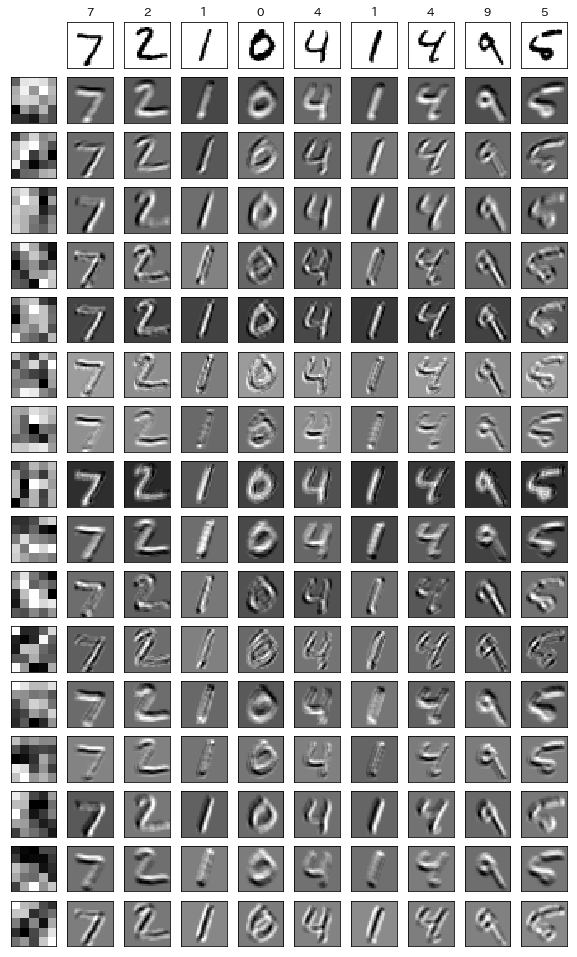

In [35]:
num_filters = 16
fig = plt.figure(figsize=(10,num_filters+1))

# フィルターを表示
for i in range(num_filters):
    subplot = fig.add_subplot(num_filters+1, 10, 10*(i+1)+1)  # https://openbook4.me/sections/1696
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

# 元の画像とそれにフィルターをかけた値を表示
for i in range(9):
    # 元の画像データを表示
    subplot = fig.add_subplot(num_filters+1, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(mnist.test.labels[i]))
    subplot.imshow(mnist.test.images[i].reshape((28,28)),
                   vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')

    # 畳こみ後の画像を表示
    for f in range(num_filters):
        subplot = fig.add_subplot(num_filters+1, 10, 10*(f+1)+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(conv_vals[i,:,:,f],  # conv_vals[i,:,:,f] : i番目のデータのf番目フィルターによる畳み込み後の画像
                       cmap=plt.cm.gray_r, interpolation='nearest')

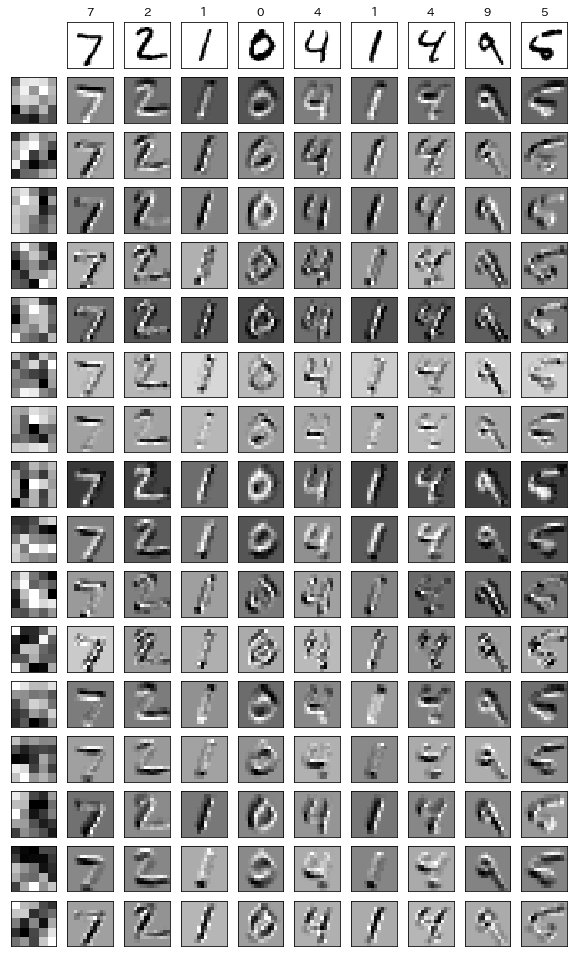

In [36]:
fig = plt.figure(figsize=(10,num_filters+1))

for i in range(num_filters):
    subplot = fig.add_subplot(num_filters+1, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

for i in range(9):
    subplot = fig.add_subplot(num_filters+1, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(mnist.test.labels[i]))
    subplot.imshow(mnist.test.images[i].reshape((28,28)),
                   vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')

    for f in range(num_filters):
        subplot = fig.add_subplot(num_filters+1, 10, 10*(f+1)+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(pool_vals[i,:,:,f],
                       cmap=plt.cm.gray_r, interpolation='nearest') 

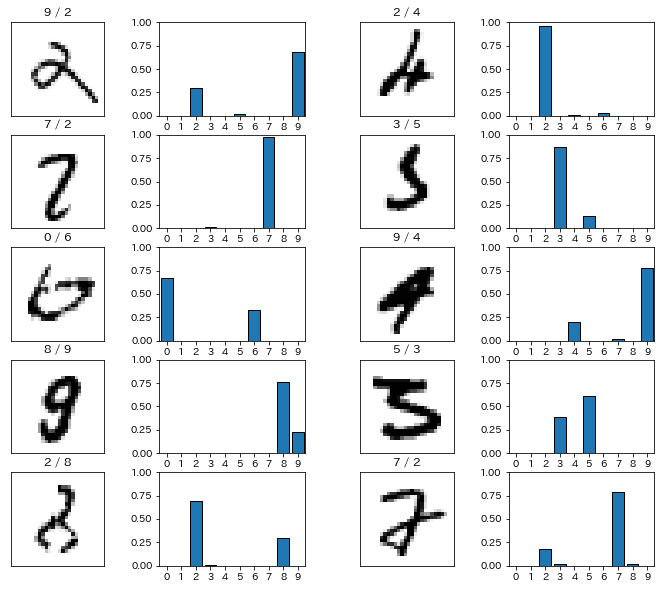

In [42]:
fig = plt.figure(figsize=(12,10))
c=0
for (image, label) in zip(mnist.test.images, 
                          mnist.test.labels):
    p_val = model.predict(image.reshape(-1, 28, 28, 1))
    pred = p_val[0]  # p_val shape = (1, 10)
    prediction, actual = np.argmax(pred), np.argmax(label)
    if prediction == actual:
        continue  # 予想と結果が合っていれば continue
    subplot = fig.add_subplot(5,4,c*2+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d / %d' % (prediction, actual))
    subplot.imshow(image.reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation="nearest")
    subplot = fig.add_subplot(5,4,c*2+2)
    subplot.set_xticks(range(10))
    subplot.set_xlim(-0.5,9.5)
    subplot.set_ylim(0,1)
    subplot.bar(range(10), pred, align='center')
    c += 1
    if c == 10:  # 10枚描画できたら終了
        break